# What is a Percentile Rank?

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1d2k082/question_whats_the_difference_between_cumulative/).

> What's the difference between cumulative frequency as a percentage and percentiles?
>
> Example that got me super confused:

[Here's the data provided by OP]:

In [1]:
import pandas as pd

columns = ['score', 'frequency', 'cumulative frequency', 'cumulative percentage']

data = [
    (8, 1, 1, 2),
    (9, 1, 2, 4),
    (10, 1, 3, 6),
    (11, 3, 6, 13),
    (12, 5, 11, 23),
    (13, 7, 18, 38),
    (14, 8, 26, 54),
    (15, 9, 35, 73),
    (16, 6, 41, 85),
    (17, 4, 45, 94),
    (18, 2, 47, 98),
    (19, 1, 48, 100),
]
df = pd.DataFrame(data, columns=columns)
df

,score,frequency,cumulative frequency,cumulative percentage
0,8,1,1,2
1,9,1,2,4
2,10,1,3,6
3,11,3,6,13
4,12,5,11,23
5,13,7,18,38
6,14,8,26,54
7,15,9,35,73
8,16,6,41,85
9,17,4,45,94


OP continues:

> To me, the last [column], the "cumulative frequency" expressed in percentages is a percentile: it's the percentage of scores lower then or the same as the score it's calculated for.
>
> However, in my class it's explained that the percentile for score 14 would be 46, and that the percentile for score 17 would be 90, not 94.
>
> The way they arrive at this is that upper and lower limits for the percentile calculation have to be set, in the case of score 14 that would be 14 and 13, and then the percentile would be calculated as (upper limit+lower limit)/2.
>
> In the case of 14: `(38+54)/2 = 46`
>
> This makes absolutely no sense to me: why are we introducing arbitrary limits to average out when the cumulative frequency in percentages, to me, seems to meet the definition of a percentile perfectly?

What's at issue here is the definition of percentile and percentile rank.
As an example, let's consider the distribution of height, and suppose the median is 168 cm.
In that case, 168 cm is the 50th percentile, and if someone is 168 cm tall, their percentile rank is 50%.

By this definition, the percentile rank for a particular quantity is its cumulative frequency expressed as a percentage, exactly as OP suggests.
If you are taller than, or the same height as, 50% of the population, your percentile rank is 50%.

However, some classes teach the alternative definition OP presents.
So, let me explain the two definitions, and we can discuss the pros and cons.
At the risk of giving away the ending, here is my conclusion: 

* Percentiles and percentile ranks are perfectly well defined, and I don't think we should encourage variations on the definitions.

* In a dataset with many repeated values, percentile ranks might not measure what we want -- in that case we might want to compute a different statistic, but then we should give it a different name.

In other words, I agree with OP.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/percentile_rank.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [3]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## Percentiles and percentile ranks

From the dataset OP provided, we can extract the scores and their frequencies.

In [4]:
pairs = df[['frequency', 'score']].values

And we can reconstitute the sample by making the given number of copies of each score.

In [5]:
sample = np.concatenate([[score] * freq for freq, score in pairs])
sample

array([ 8,  9, 10, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 19])

Now suppose we want to compute the median score and the interquartile range (IQR).
We can use the NumPy function `percentile` to compute the 25th, 50th, and 75th percentiles.

In [6]:
np.percentile(sample, [25, 50, 75])

array([13., 14., 16.])

So the median score is 14 and the IQR is `16 - 13 = 3`.

Going in the other direction, if we are given a score, `q`, we can compute its percentile rank by computing the fraction of scores less than or equal to `q`, expressed as a percentage.

In [7]:
q = 14
np.mean(sample <= q) * 100

54.166666666666664

If someone gets the median score of `14`, their percentile rank is about 54%.

Here we see the first thing that bothers people about percentiles and percentile ranks: with a finite dataset, they are not invertible.
If you compute the percentile rank of the 50th percentile, the answer is not always 50%.
To see why, let's consider the CDF.

## The CDF

Percentiles and percentile ranks are closely related to the the cumulative distribution function (CDF).
To demonstrate, we can use `empiricaldist` to make a `Cdf` object from the reconstituted sample.

In [8]:
from empiricaldist import Cdf

cdf = Cdf.from_seq(sample)
cdf

,probs
8,0.020833
9,0.041667
10,0.062500
11,0.125000
12,0.229167
13,0.375000
14,0.541667
15,0.729167
16,0.854167
17,0.937500


A `Cdf` object is a Pandas `Series` that contains the observed quantities as an index and their cumulative probabilities as values.
We can use square brackets to look up a quantity and get a cumulative probability.

In [9]:
cdf[14]

0.5416666666666666

If we multiply by 100, we get the percentile rank.

But square brackets only work with quantities in the dataset.
If we look up any other quantity, that's an error.
However, we can use parentheses to call the `Cdf` object like a function.

In [10]:
cdf(14)

array(0.54166667)

And that works with any numerical quantity.

In [11]:
cdf(13.5)

array(0.375)

`Cdf` provides a `step` method that plots the CDF as a step function, which is what it technically is.

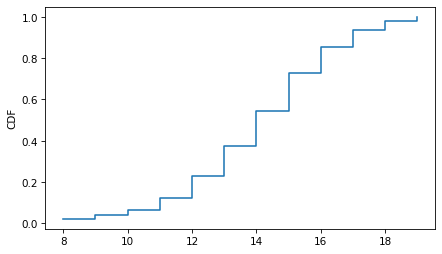

In [12]:
cdf.step(label='')
decorate(ylabel='CDF')

To be more explicit, we can put markers at the top of each vertical segment to indicate how the function is evaluated at one of the observed quantities.

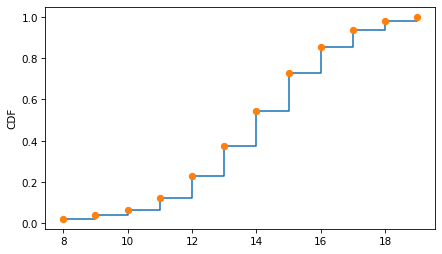

In [13]:
cdf.step(label='')
cdf.plot(style='o', label='')
decorate(ylabel='CDF')

The `Cdf` object provides a method called `inverse` that computes the inverse CDF -- that is, if you give it a cumulative probability, it computes the corresponding quantity.

In [14]:
p1 = 0.375
cdf.inverse(p1)

array(13.)

The result from an inverse lookup is sometimes called a "quantile", which is the name of a Pandas method that computes quantiles.

If we put the sample into a `Series`, we can use `quantile` to compute the quantity to look up the cumulative probability `p1`.

In [15]:
sample_series = pd.Series(sample)
sample_series.quantile(p1)

13.625

By default, `quantile` uses interpolates linearly between the observed values.
If we want this function to behave according to the definition of the CDF, we have to specify a different kind of interpolation.

In [16]:
sample_series.quantile(p1, interpolation='lower')

13

If the result from the inverse CDF is called a quantile, you might wonder what we call the result from the CDF.
By analogy with percentile and percentile rank, I think it should be called a quantile rank, but no one calls it that.
As far as I can tell, it's just called a cumulative probability.

## So what's wrong with percentile rank?

Percentiles and percentile ranks have a perfectly good definition, which follows from the definition of the CDF.
So what's the problem?
Well, I have to admit -- the definition is a little arbitrary.

In the example, suppose your score is 14.
Your score is strictly better than 37.5% of the other scores.

In [17]:
less = np.mean(sample < 14)
less

0.375

It's strictly worse than 45.8%

In [18]:
more = np.mean(sample > 14)
more

0.4583333333333333

And equal to 16.7%.

In [19]:
same = np.mean(sample == 14)
same

0.16666666666666666

So if we want a single number that quantifies your performance relative to the rest of the class, which number should we use?

The definition of the CDF suggests we should report the fraction of the class whose score is *less than or equal* to yours.
But that is an arbitrary choice.
We could just as easily report the fraction whose score is strictly less -- or the midpoint of these extremes.
For a score of 14, here's the midpoint:

In [20]:
less + same / 2

0.4583333333333333

That's the result OP's teacher was expecting, and to be fair, that's [Wikipedia's definition of percentile rank](https://en.wikipedia.org/wiki/Percentile_rank).
But I don't like it.

## Discussion

I prefer the CDF-based definition of percentile rank because it's consistent with the way most computational tools work.
The midpoint-based definition feels like a holdover from the days of working with small datasets by hand.

That's just my preference -- if people want to compute midpoints, I won't stop them.
But for the sake of clarity, we should give different names to different statistics.

Historically, I think the CDF-based definition has the stronger claim on the term "percentile rank".
For the midpoint-based definition, ChatGPT suggests "midpoint percentile rank" or "average percentile rank".
Those seem fine to me, but it doesn't look like they are widely used.

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)